In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
import seaborn as sns
import re
pd.set_option('display.max_columns', 500)

# for plotting
from itertools import cycle
color_pal=plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle=cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])


#load in the dataset


In [11]:
from google.colab import files
files.upload()

Saving tweets.csv to tweets.csv


In [12]:
import pandas as pd

tweets = pd.read_csv('/content/tweets.csv')

In [13]:
def process_tweets(tweets):
    tweets['tweet_datetime'] = pd.to_datetime(tweets['tweet_date'])
    tweets['tweet_date'] = tweets['tweet_datetime'].dt.date
    tweets['wordle_id'] = tweets['tweet_text'].str[:10]
    tweets['n_attempts'] = tweets['tweet_text'].str[11].astype('int')
    tweets['id'] = tweets['tweet_text'].str[7:10].astype('int')
    return tweets

tweets = process_tweets(tweets)

#How many tweets do we have for each date

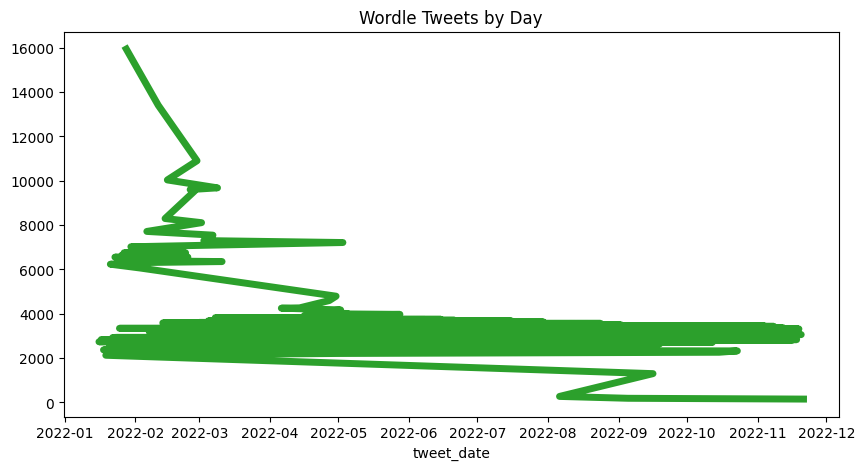

In [14]:
tweets['tweet_date'].value_counts() \
    .plot(figsize=(10, 5), title='Wordle Tweets by Day',
          color=color_pal[2], lw=5)
plt.show()


#Number of Attempts analysis by Wordle ID

In [15]:
tweets.groupby('wordle_id')['n_attempts'].value_counts() \
    .unstack() \
    .style.background_gradient(axis=1)

n_attempts,2,3,4,5,6
wordle_id,,,,,
Wordle 210,222,897,1064,489,165
Wordle 211,196,903,1016,564,215
Wordle 212,191,787,820,413,188
Wordle 213,51,260,630,697,481
Wordle 214,383,1012,823,363,122
Wordle 215,246,877,1017,579,224
Wordle 216,461,1952,2078,1199,415
Wordle 217,102,566,1031,843,418
Wordle 218,170,1009,1384,730,187


#How many attempts does it ususally take to solve?

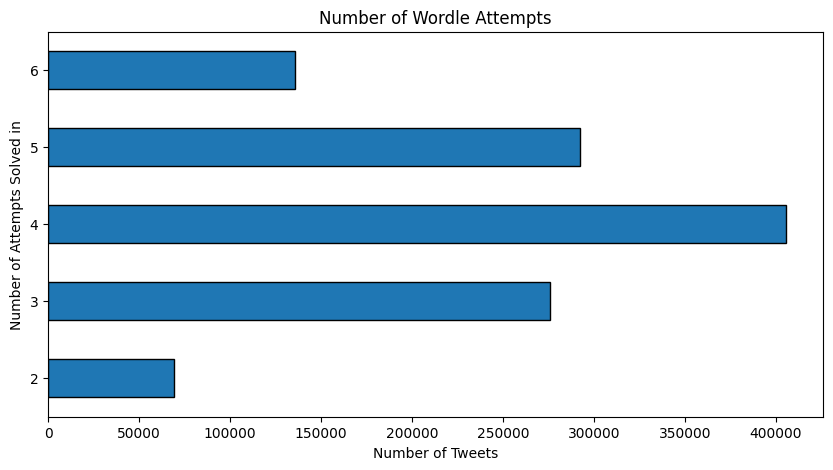

In [16]:
ax = tweets['n_attempts'].value_counts() \
    .sort_index() \
    .plot(figsize=(10, 5),
          kind='barh',
          title='Number of Wordle Attempts',
          edgecolor='black')
ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Number of Attempts Solved in')
plt.show()

#Parse Tweet Text

In [17]:
# Make dark squares consistent
tweets['tweet_text'] = tweets['tweet_text'].str.replace('⬜','⬛')

In [18]:
def parse_tweet_text(tweets):
    for n in range(6):
        n += 1

        tweets[f'has_guess{n}'] = (
            tweets['tweet_text']
            .str.split('\n')
            .str[n + 1]
            .str.contains('|'.join(['🟨', '⬛', '🟩']))
            .fillna(False)
        )

        # Parse out the tweet text
        tweets.loc[tweets[f'has_guess{n}'], f'guess{n}'] = (
            tweets['tweet_text']
            .str.split('\n')
            .str[n + 1]
            .str[:5]
        )

        # Count number correct, misplaced, and incorrect
        tweets.loc[tweets[f'has_guess{n}'], f'guess{n}_incorrect'] = (
            tweets[f'guess{n}'].str.count('⬛')
        )

        tweets.loc[tweets[f'has_guess{n}'], f'guess{n}_wrong_spot'] = (
            tweets[f'guess{n}'].str.count('🟨')
        )

        tweets.loc[tweets[f'has_guess{n}'], f'guess{n}_correct'] = (
            tweets[f'guess{n}'].str.count('🟩')
        )

        tweets.loc[tweets[f'guess{n}_correct'] == 6, 'final_guess'] = n

    return tweets


tweets = parse_tweet_text(tweets)

/tmp/ipython-input-4267779017.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)
/tmp/ipython-input-4267779017.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)
/tmp/ipython-input-4267779017.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)
/tmp/ipython-input-4267779017.py:10: FutureWar

In [19]:
# Keep additional tweet text
tweets['additional_text'] = \
    tweets.loc[~tweets['tweet_text'] \
    .str.split('\n').str[-1].str.contains('🟩')] \
    ['tweet_text'].str.split('\n').str[-1]

#Plot Results by Attempt

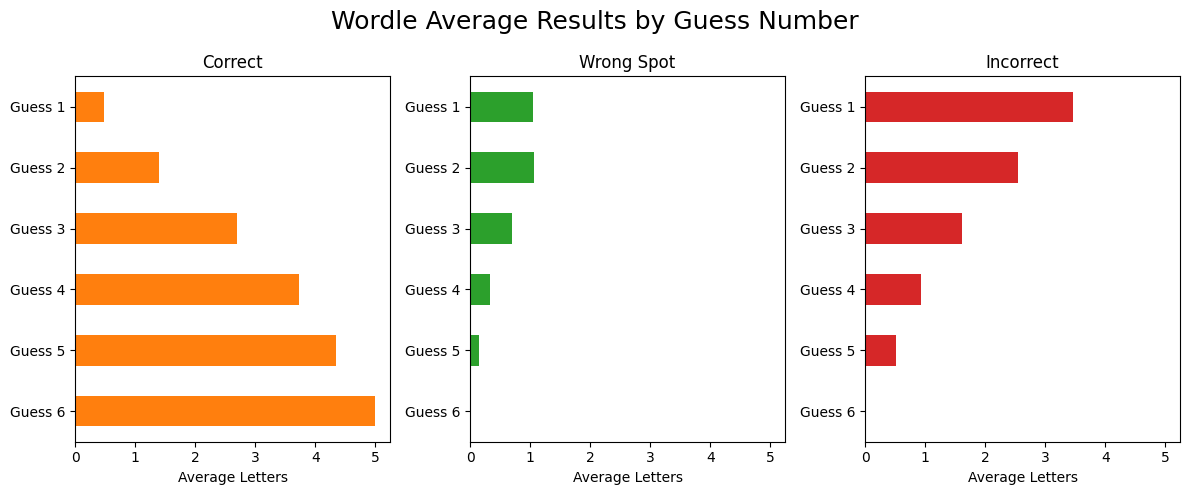

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex=True)

for i, x in enumerate(['_correct','_wrong_spot','_incorrect']):
    col_subset = [c for c in tweets.columns if x in c]
    guess_avg = tweets[col_subset].mean()
    guess_avg.index = [f'Guess {i+1}' for i in range(6)]
    guess_avg.sort_index(ascending=False) \
        .plot(kind='barh',
              title=f'{x.strip("_").replace("_"," ").title()}',
              ax=axs[i],
              color=color_pal[i+1])
    axs[i].set_xlabel('Average Letters')
fig.suptitle('Wordle Average Results by Guess Number', fontsize=18)
plt.tight_layout()
plt.show()

#Letter Analysis

In [22]:
tweets.columns

Index(['wordle_id', 'tweet_id', 'tweet_date', 'tweet_username', 'tweet_text',
       'tweet_datetime', 'n_attempts', 'id', 'has_guess1', 'guess1',
       'guess1_incorrect', 'guess1_wrong_spot', 'guess1_correct',
       'final_guess', 'has_guess2', 'guess2', 'guess2_incorrect',
       'guess2_wrong_spot', 'guess2_correct', 'has_guess3', 'guess3',
       'guess3_incorrect', 'guess3_wrong_spot', 'guess3_correct', 'has_guess4',
       'guess4', 'guess4_incorrect', 'guess4_wrong_spot', 'guess4_correct',
       'has_guess5', 'guess5', 'guess5_incorrect', 'guess5_wrong_spot',
       'guess5_correct', 'has_guess6', 'guess6', 'guess6_incorrect',
       'guess6_wrong_spot', 'guess6_correct', 'additional_text'],
      dtype='object')

In [23]:
first_guess_correct = []

for i, d in tweets.dropna(subset=['guess1']).iterrows():
    example_text = d['guess1']
    results = [x.span()[0] for x in re.finditer('🟩', example_text)]
    first_guess_correct += results

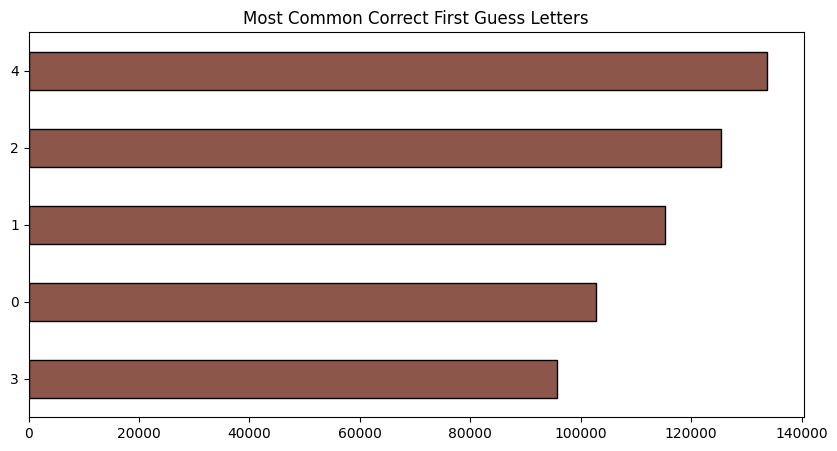

In [24]:
pd.Series(first_guess_correct).value_counts(ascending=True) \
    .plot(kind='barh', figsize=(10, 5),
         title='Most Common Correct First Guess Letters',
         edgecolor='black', color=color_pal[5])
plt.show()